## 6S equivalent atmospheric correction parameters from libRadtran

Feng Yin  
Department of Geography, UCL  
ucfafyi@ucl.ac.uk 

### Introduction

Unlike 6S, libRadtran default output are lambda, edir, edn, eup, uavgdir, uavgdn, uavgup at user defined zout, which cannot be directly used for atmospheric correction. While 6S directly gives three parameters **xap**, **xb** and **xc**, and which can be used directly to turn the TOA reflectance into surface reflectance if the surface is assumed to be lambertian. Thus in this repository, I am going to derive 6S equivalent atmospheric correction parameters from libRadtran and this should be also applicable to other radiavtive transfer equations, such as MODTRAN.


Let's first have a look at all the different input and output parameters used in libRadtran:

#### <center>LibRadtran parameters table:</center>

parameter | physical meaning |
:-----|:---------------------------------------|
lambda | Wavelength $nm$  
wavelength | Wavelength $nm$  
wavenumber | Wavenumber $cm^1$  
wvn | Wavenumber $cm^-1$  
wvl | Wavelength $nm$  
edir | Direct beam irradiance (same unit as extraterrestrial irradiance |  e.g mW/m^2/nm if using the "atlas3" spectrum in the /data/solar_flux/ directory.)  
edn | Diffuse downwelling irradiance |  i.e. total minus direct beam (same unit as edir).  
eup | Diffuse upwelling irradiance (same unit as edir).  
uavg | The mean intensity. Proportional to the actinic flux |  To obtain the actinic flux |  multiply the mean intensity by 4 pi (same unit as edir).  
uavgdir | Direct beam contribution to the mean intensity. (same unit as edir).  
uavgdn | Diffuse downward radiation contribution to the mean intensity. (same unit as edir).  
uavgup | Diffuse upward radiation contribution to the mean intensity. (same unit as edir).  
umu | Cosine of the zenith angles for sightline radiance (intensity) calculations.  
u0u | The azimuthally averaged intensity at n_umu user specified angles umu. (units of e.g. mW/m^2/nm/sr if using the "atlas3" spectrum in the /data/solar_flux/ directory.)   
uu | The radiance (intensity) at umu and phi user specified angles (unit e.g. mW/m^2/nm/sr if using the "atlas3" spectrum in the /data/solar_flux/ directory.)   
uu_down | The downwelling radiances (intensity) at cmu and phi angles (unit e.g. mW/m^2/nm/sr if using the "atlas3" spectrum in the /data/solar_flux/ directory.)  
uu_up | The upwelling radiances (intensity) at cmu and phi angles (unit e.g. mW/m^2/nm/sr if using the "atlas3" spectrum in the /data/solar_flux/ directory.)   
cmu | Computational polar angles from polradtran  
down_fluxI | The total (direct+diffuse) downward (down flux) irradiances (Stokes I component). Same units as extraterrestrial irradiance.  
up_fluxI | The total (direct+diffuse) upward (up flux) irradiances (Stokes I component). Same units as extraterrestrial irradiance.  
down_fluxQ | The total (direct+diffuse) downward (down flux) irradiances (Stokes Q component). Same units as extraterrestrial irradiance.  
up_fluxQ | The total (direct+diffuse) upward (up flux) irradiances (Stokes Q component). Same units as extraterrestrial irradiance.  
down_fluxU | The total (direct+diffuse) downward (down flux) irradiances (Stokes U component). Same units as extraterrestrial irradiance.  
up_fluxU | The total (direct+diffuse) upward (up flux) irradiances (Stokes U component). Same units as extraterrestrial irradiance  
down_fluxV | The total (direct+diffuse) downward (down flux) irradiances (Stokes V component). Same units as extraterrestrial irradiance.  
up_fluxV | The total (direct+diffuse) upward (up flux) irradiances (Stokes V component). Same units as extraterrestrial irradiance.  
eglo | Global downwelling irradiance  
enet | Global downwelling minus upwelling (net downward irradiance)  
esum | Global downwelling plus upwelling  
fdir | Direct actinic flux (scalar irradiance)  
fglo | Global actinic flux (scalar irradiance)  
fdn | Downwelling actinic flux (scalar irradiance)  
fup | Upwelling actinic flux (scalar irradiance)  
uavgglo | Total (global) mean diffuse intensity (radiance) = actinic flux/4pi  
f | Actinic flux (scalar irradiance)  
sza | Solar zenith angle $deg$  
n_air | Air refractive index  
zout | Altitude above ground $km$  
zout_sea | Altitude above sea level $km$  
sph_alb | Spherical albedo of the complete atmosphere  
albedo | Albedo  
heat | Heating rate in K/day  
n_xxx | Number density of gas xxx $cm^-3$  
rho_xxx | Mass density of gas xxx $kg/m^3$  
mmr_xxx | Mass mixing ratio of gas xxx $kg/kg$  
vmr_xxx | Volume mixing ratio of gas xxx $m^3/m^3$  
p | Pressure $hPa$  
T | Temperature $K$  
T_d | Dewpoint temperature $K$  
T_sur | Surface temperature $K$  
sur_temperature | Surface Temperature $K$  
theta | Potential temperature $K$  
theta_e | Equivalent potential temperature $K$  
rh | Relative humidity over water $\%$  
rh_ice | Relative humidity over ice $\%$  
c_p | Specific heat capacity of the air  
CLWC | Cloud liquid water content $kg/kg$  
CLWD | Cloud liquid water density $g/m^3$  
CIWC | Cloud ice water content $kg/kg$  
CIWD | Cloud ice water density $g/m^3$  
TCC | Total cloud cover $0-1$  
cth | Cloud top height $km$

which is **a lot**, but **none** of these tells us how to correct for atmosphere effects if we want to do atmospheric correction with it...

### Some math equations

The way 6S calculate atmospheric correction parameters for lambertian albedo is through ([Vermote et al., 1997]):

$$
\rho_{toa} = \rho_{path} + \frac{T\rho_{sur}}{1 - s\rho_{sur}}
$$

where $\rho_{toa}$ is the reflectance at TOA, $\rho_{path}$ is the atmospheric intrinsic reflectance which represent radiance reflectance by atmosphere only without the influence from surface, $T$ represents the double (up and down) trasmittance of the atmosphere, $s$ stands for the spherical albedo of atmosphere intoduced by the multiple scattering between the surface and atmosphere and $\rho_{sur}$ is the surface reflectance for lambertian surface. $\rho_{path}$, $s$ and $T$ are independent from $\rho_{sur}$. Following ([Guanter et al., 2009]; [Tanre et al., 1997]; [Richter 1990]):


$$
\begin{equation}
L_p(\rho) = L_p(0) + t_{dif}^{up} E_g(\rho)\rho/\pi
\label{eq:1}
\tag{1}
\end{equation}
$$

where $L_p(\rho)$ is the atmosphere path radiance at surface albedo $\rho$, $L_p(0)$ is the atmosphere intrinsic radiance, $t_{dif}^{up}$ is diffuse upward transmittance, $E_g(\rho)$ is the global flux reaching the surface (travel from sun to surface). The meaning of this equation is the atmosphere path radiance is a sum of atmosphere intrinsic radiance (no interaction with the surface) and the reflectanted flux by the surface and travel upward to the sensor at a specific surface albedo.

$$
\begin{equation}
L_{toa}(\rho) = L_p(\rho) + t_{dir}^{up} E_g(\rho)\rho/\pi
\label{eq:2}
\tag{2}
\end{equation}
$$

where $L_{toa}(\rho)$ is the total radiance received by the sensor and $t_{dir}^{up}$ is the direct upward transmittance. The meaning of this equation is that the TOA radiance is a sum of atmosphere path radiance and the directly reflected global flux reaching the surface by surface with albedo of $\rho$. Actually, putting those two equations together, we can see that the TOA radiance is a sum of atmosphere intrinsic radiance, direct and diffuse radiance travelling upward trought the atmosphere after the solar irradiance travel downward reching the surface and reflected by surface with albedo of $\rho$.


Let $T^{up} = t_{dif}^{up} + t_{dir}^{up}$ and try to obtain the atmospheric parameters free from the effects of surface albedo, we have:

$$
\begin{equation}
L_{toa}(\rho) = L_p(0) + \frac{T^{up} E_g(0)\rho/\pi}{1 - s\rho}
\label{eq:3}
\tag{3}
\end{equation}
$$


Adding equation $\eqref{eq:1}$ and $\eqref{eq:2}$ and comparing to $\eqref{eq:3}$, we have:

$$
\begin{equation}
\frac{T^{up} E_g(0)\rho/\pi}{1 - s\rho} = T^{up} E_g(\rho)\rho/\pi
\label{eq:4}
\tag{4}
\end{equation}
$$

With two surface albedo $\rho_1$ and $\rho_2$, we can solve spherical albedo by collecting the global flux reaching surface which is given by libRadtran as **eglo**:

$$
\begin{equation}
s = \frac{E_g(\rho_1) - E_g(\rho_2)}{\rho_1 E_g(\rho_1) - \rho_2 E_g(\rho_2)}
\label{eq:5}
\tag{5}
\end{equation}
$$

Also libRadtran gives the TOA radiance as $uu$, which then can be used with $\eqref{eq:3}$ with two albedo to get $T^{up}$:

$$
\begin{equation}
T^{up} = \frac{(L_{toa}(\rho_1) - L_{toa}(\rho_1))(1 - s\rho_1)(1 - s\rho_2)}{\rho_1 (1 - s\rho_2)- \rho_2 (1 - s\rho_1)}
\label{eq:6}
\tag{6}
\end{equation}
$$

Then the atmosphere intrinsic radiance can be calculated from $\eqref{eq:3}$ with either $\rho_1$ or $\rho_2$
$$
\begin{equation}
L_p(0) = L_{toa}(\rho) - \frac{T^{up} E_g(0)\rho/\pi}{1 - s\rho}
\label{eq:7}
\tag{7}
\end{equation}
$$

Also we have $E_g(0) = E_{solar}T_{down}$, the total flux at surface is the solar flux travelling downward from the space through atmosphere with transmittance of $T_{down}$ (can be splited into direct and diffuse, but not important for this case) to the surface. We also have $T = T^{up}T_{down}$ (double transmittance), then:

$$
\begin{equation}
L_{toa}(\rho) = L_p(0) + \frac{T E_s\rho/\pi}{1 - s\rho}
\label{eq:8}
\tag{8}
\end{equation}
$$

If equation is $\eqref{eq:8}$ normalised by solar flux, we end up having exactly the same format as  $\eqref{eq:1}$.





[Guanter et al., 2009]:https://doi.org/10.1080/01431160802438555
[Vermote et al., 1997]:https://ieeexplore.ieee.org/iel1/36/12630/00581987.pdfs
[Tanre et al., 1997]:http://finalfrontier.ucsd.edu/Projects/NF-POGO/Tanre79.pdf
[Richter 1990]:https://www.tandfonline.com/doi/abs/10.1080/01431169008955008

According to those equations, we can run libRadtran 2 times with 2 differnet $\rho$ values, and collect the **eglo** at surface level and **uu** at TOA, then we should be able to compute those paramerters. Before we do it in the way I explained above, there are other ways to compute those parameters and I am going to explain them as well.

The installation of libRadtran is not so straightforward as it is mentioned in the user manual, which mainly relates to the different dependencies cross different operation platforms. Fortunately, conda allows users to easily install different versions of binary software packages and any required libraries appropriate for their computing platform. After some (actually a lot) trial and error, I have created the libRadtran conda package, which should be easilly installed through anaconda cloud:

### installation

`conda install -c f0xy libradtran`

After that, the calling of libRadtran is simply done by using command line code: **uvspec**

In [23]:
import os
import requests
import tarfile
import subprocess

if not os.path.exists('libRadtran-2.0.2/'):
    libradtran = 'http://www.libradtran.org/download/libRadtran-2.0.2.tar.gz'
    reptran    = 'http://www.meteo.physik.uni-muenchen.de/~libradtran/lib/exe/fetch.php?media=download:reptran_2017_all.tar.gz'
    opac       = 'http://www.meteo.physik.uni-muenchen.de/~libradtran/lib/exe/fetch.php?media=download:optprop_v2.1.tar.gz'
    r = requests.get(libradtran)
    with open('libRadtran.tar.gz', 'wb') as f:
        f.write(r.content)
    tar = tarfile.open("libRadtran.tar.gz")
    tar.extractall()
    tar.close()

    r = requests.get(reptran)
    with open('libRadtran-2.0.2/reptran_2017_all.tar.gz', 'wb') as f:
        f.write(r.content)
    tar = tarfile.open("libRadtran-2.0.2/reptran_2017_all.tar.gz")
    tar.extractall(path='libRadtran-2.0.2')
    tar.close()

    r = requests.get(reptran)
    with open('libRadtran-2.0.2/optprop_v2.1.tar.gz', 'wb') as f:
        f.write(r.content)
    tar = tarfile.open("libRadtran-2.0.2/optprop_v2.1.tar.gz")
    tar.extractall(path='libRadtran-2.0.2')
    tar.close()
    
if not os.path.exists('6SV2.1'):
    r = requests.get('http://6s.ltdri.org/files/update/6sV-2.1.tar')
    with open('6sV-2.1.tar', 'wb') as f:
        f.write(r.content)
    tar = tarfile.open("6sV-2.1.tar")
    tar.extractall(path='6SV2.1')
    cwd = os.getcwd()
    subprocess.Popen(["make"], stdout=subprocess.PIPE, cwd="6SV2.1")
    tar.close()
    

In [11]:
%%bash
uvspec -h


uvspec, version 2.0.2-MYSTIC

Calculates the radiation field of the Earth's atmosphere.
See libRadtran documentation for more information.


Radiative transfer is a complex problem. Make sure
you understand both the problem you try to solve and the
tools you use to solve it.


Usage: uvspec [-h] < input_file > Output_file
 -h             Print this message.
 -v             Print version number.
 -c             Checks if the syntax of the input file is correct,
                then exit. NO radiation calculated.
 -i input_file  Alternative way to specifiy the input file.
 -f input_file  Same as -i.



A demo input file `Test.Inp`:

```
data_files_path libRadtran-2.0.2/data/ # specify the libRadtran metadata directory     
atmosphere_file US-standard    # choose US-standard atmosphere file
source solar libRadtran-2.0.2/data/solar_flux/kurudz_1.0nm.dat # chose the Kurudz solar spectrum 

mol_modify H2O 34.000000 MM  # modify the Total column of water vapour
mol_modify O3 300.000000 DU  # modify the Total column of Ozone

mol_abs_param reptran # chose the atmosphere gas absorption (fine/medium/coarse)

rte_solver disort # radiative transfer solver

number_of_streams 16 # Number of streams used to solve the radiative transfer equation

aerosol_default # specify the aerosol to be continental with AOT at 550 to be 0.2
aerosol_species_file  continental_average    
aerosol_set_tau_at_wvl 550 0.200000 

wavelength 400.00000000 2500.00000000     # set the computation wavelength

umu 0.996 # cosine of view zenith angle np.cos(np.deg2rad(5))

albedo 0.1 # surface albedo

altitude 0. # surface elevation

zout sur toa # specify the output altidude (this can be different from surface elevation)

output_user lambda eglo # the output parameters (one per column for all the specified zout)
quiet
```

In [43]:
!uvspec < Test.Inp > Test.out

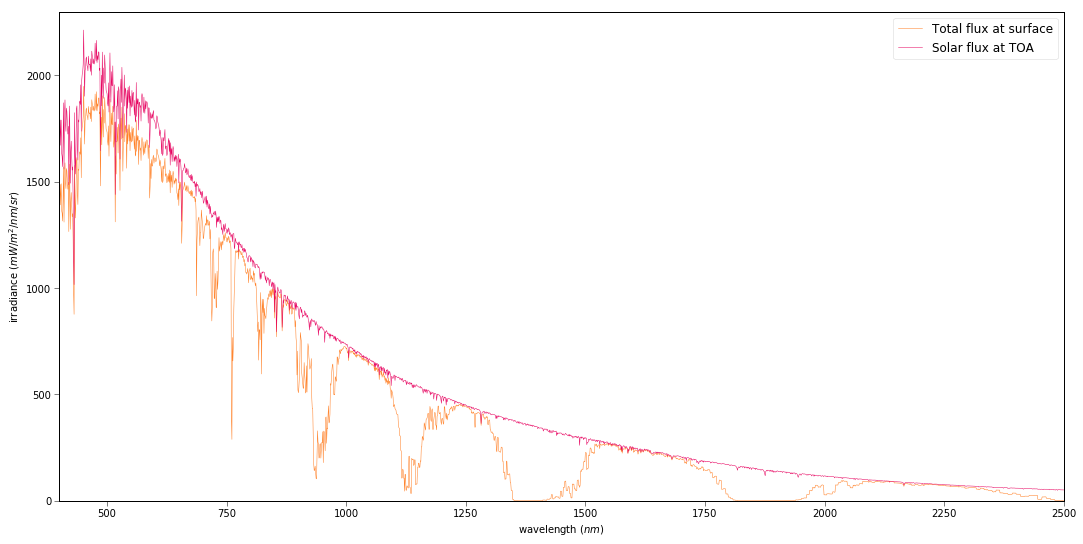

In [3]:
import numpy as np
import pylab as plt
%matplotlib inline

ret = np.genfromtxt('Test.out') # get the output as array
wv, eglo  = ret[::2].T # since we specified zout first as sur so we get total flux at surface level
wv, es    = ret[1::2].T # total flux at TOA (solar flux)
plt.figure(figsize=(18, 9))
plt.plot(wv, eglo, color = '#ff7f24', lw=0.5, label='Total flux at surface')
plt.plot(wv, es,   color = '#e7025f', lw=0.5, label='Solar flux at TOA')
plt.xlabel(r'wavelength ($nm$)')
plt.ylabel(r'irradiance ($mW/m^2/nm/sr$)')
plt.xlim(400, 2500)
plt.ylim(0, 2300)
plt.legend(fontsize='large')

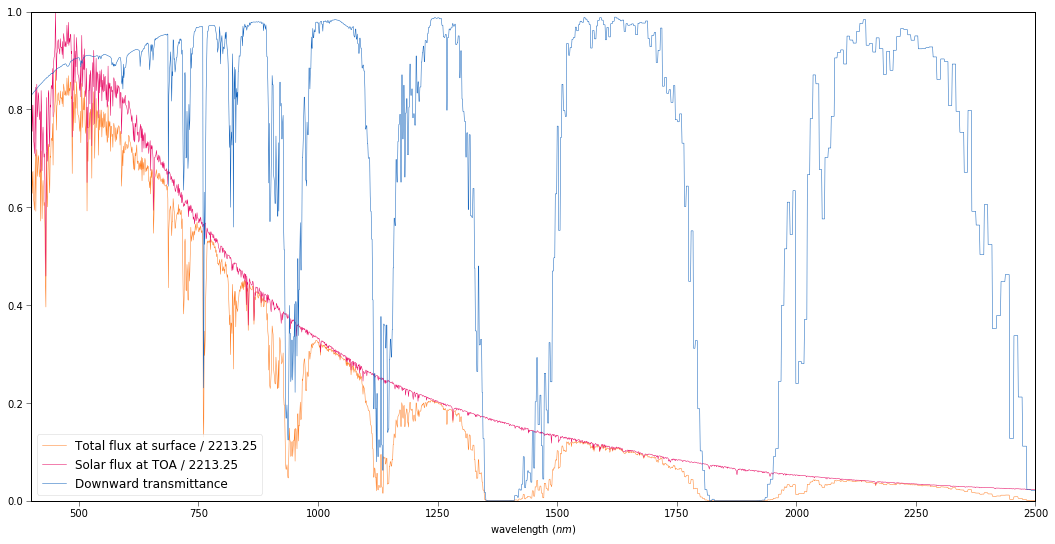

In [3]:
# then we can get the downward transmittance by
# the ratio between the TOA flux and surface flux
T_down = eglo/es
plt.figure(figsize=(18, 9))
plt.plot(wv, eglo/es.max(), color = '#ff7f24', lw=0.5, label='Total flux at surface / %.02f'%(es.max()))
plt.plot(wv, es/es.max(),   color = '#e7025f', lw=0.5, label='Solar flux at TOA / %.02f'%(es.max()))
plt.plot(wv, T_down,        color = '#1162bc', lw=0.5,   label = 'Downward transmittance')
plt.ylim(0,1)
plt.xlim(400, 2500)
plt.xlabel(r'wavelength ($nm$)')
plt.legend(loc='best', fontsize='large')

Let's have a look at solar-induced chlorophyll fluorescence

### Fluorescence wavelength

>The F signal is comparably stronger and can be detected passively in narrow dark lines of the solar and atmospheric spectrum in which irradiance is strongly reduced (the so-called Fraunhofer lines). In the visible and near-infrared, the solar spectrum at ground level exhibits three main “Fraunhofer” features which have been exploited for F estimation: $H\alpha$ due to hydrogen ($H$) absorption in the solar atmosphere (centered at 656.4 $nm$) and two telluric oxygen ($O_2$) absorption bands in the Earth atmosphere, $O_2$-B (687.0 $nm$) and $O_2$-A (760.4 $nm$)

([Meroni et al., 2009]).

So focus on those wavelength by running libRadtran at a finner resolution should shows those Fraunhofer lines.


```
data_files_path libRadtran-2.0.2/data/ # specify the libRadtran metadata directory     
atmosphere_file US-standard    # choose US-standard atmosphere file
source solar kurudz_400_2500_0.01nm.dat # use solar interpolated by myself to have 0.01 nm resolution

mol_modify H2O 34.000000 MM  # modify the Total column of water vapour
mol_modify O3 300.000000 DU  # modify the Total column of Ozone

mol_abs_param reptran fine # chose finer absorbtion you need download data from the libRadtran page

rte_solver disort # radiative transfer solver

aerosol_default # specify the aerosol to be continental with AOT at 550 to be 0.2
aerosol_species_file  continental_average    
aerosol_set_tau_at_wvl 550 0.200000 

wavelength 549 780     # set the computation wavelength (have to include 550...)

number_of_streams 16 # Number of streams used to solve the radiative transfer equation

umu 0.996 # cosine of view zenith angle np.cos(np.deg2rad(5))

albedo 0.1 # surface albedo

altitude 0. # surface elevation

zout sur # specify the output altidude (this can be different from surface elevation)

output_user lambda eglo # the output parameters (one per column for all the specified zout)
quiet
```

[Meroni et al., 2009]:https://doi.org/10.1016/j.rse.2009.05.003

In [ ]:
nwv, nss = np.loadtxt('kurudz_300_2500_0.01nm.dat').T
owv, oss = np.loadtxt('libRadtran-2.0.2/data/solar_flux/kurudz_0.1nm.dat').T
cwv, css = np.loadtxt('libRadtran-2.0.2/data/solar_flux/kurudz_1.0nm.dat').T

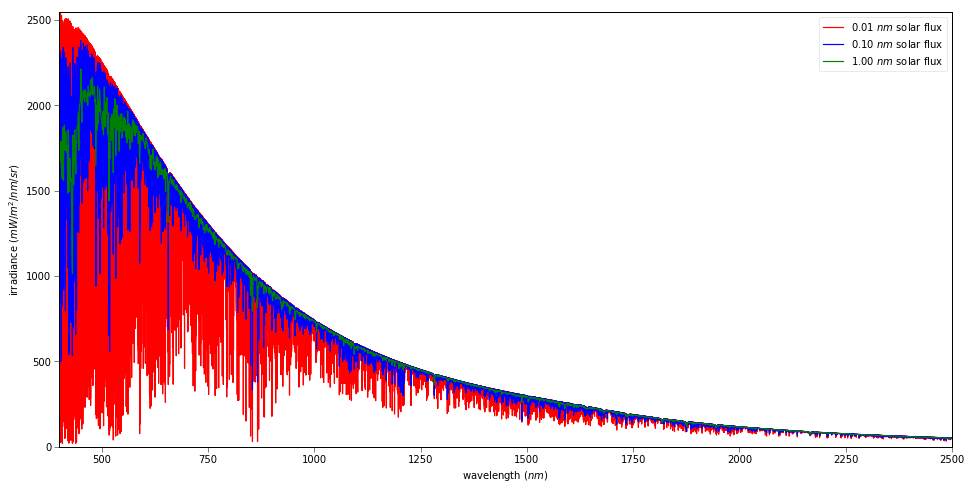

In [9]:
plt.figure(figsize=(16,8))
plt.plot(nwv, nss, 'r', label = r'0.01 $nm$ solar flux')
plt.plot(owv, oss, 'b', label = r'0.10 $nm$ solar flux')
plt.plot(cwv, css, 'g', label = r'1.00 $nm$ solar flux')
plt.xlim(400, 2500)
plt.xlabel(r'wavelength ($nm$)')
plt.ylabel(r'irradiance ($mW/m^2/nm/sr$)')
plt.legend()

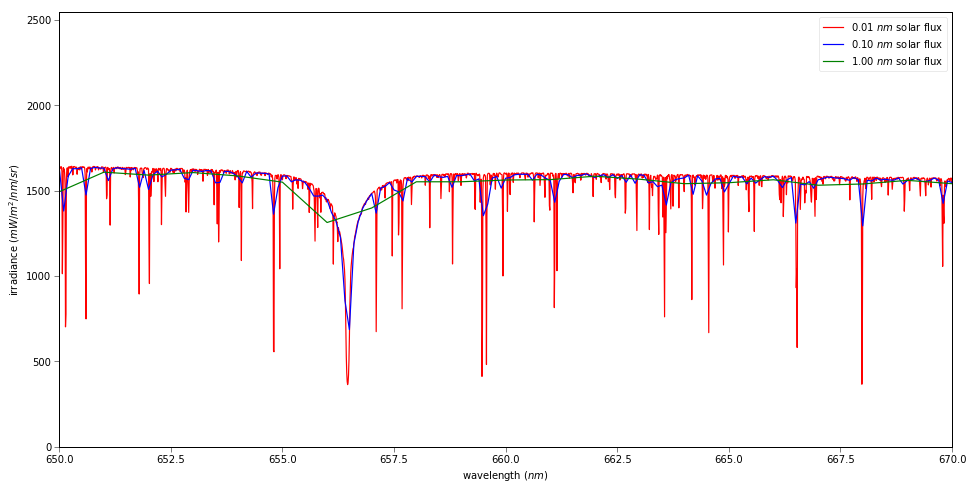

In [11]:
plt.figure(figsize=(16,8))
plt.plot(nwv, nss, 'r', label = r'0.01 $nm$ solar flux')
plt.plot(owv, oss, 'b', label = r'0.10 $nm$ solar flux')
plt.plot(cwv, css, 'g', label = r'1.00 $nm$ solar flux')
plt.xlim(650, 670)
plt.xlabel(r'wavelength ($nm$)')
plt.ylabel(r'irradiance ($mW/m^2/nm/sr$)')
plt.legend()

In [216]:
!uvspec < Fraunhofer_lines.Inp > Fraunhofer_lines.out

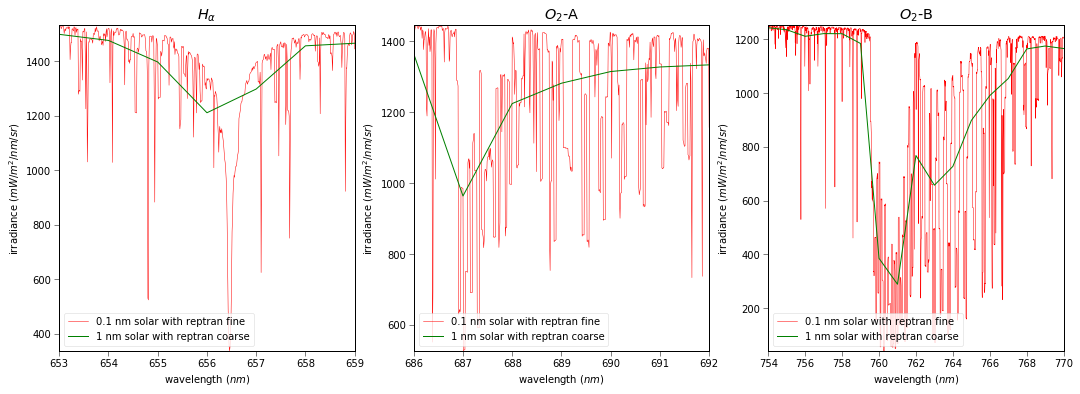

In [241]:
wv1, sur_flux = np.genfromtxt('Fraunhofer_lines.out').T
Ha_mask   = (wv1>=653) & (wv1<=659)
O2_A_mask = (wv1>=686) & (wv1<=692)
O2_B_mask = (wv1>=754) & (wv1<=770)
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 6))
axs[0].plot(wv1[Ha_mask],   sur_flux[Ha_mask],   '-', color='r', lw=0.5, label = '0.1 nm solar with reptran fine')
axs[1].plot(wv1[O2_A_mask], sur_flux[O2_A_mask], '-', color='r', lw=0.5, label = '0.1 nm solar with reptran fine')
axs[2].plot(wv1[O2_B_mask], sur_flux[O2_B_mask], '-', color='r', lw=0.5, label = '0.1 nm solar with reptran fine')
# we can also plot 1 nm resolution
Ha_mask   = (wv>=653) & (wv<=659)
O2_A_mask = (wv>=686) & (wv<=692)
O2_B_mask = (wv>=754) & (wv<=770)
axs[0].plot(wv[Ha_mask],   eglo[Ha_mask],   '-', color='g', lw=1, label = '1 nm solar with reptran coarse')
axs[1].plot(wv[O2_A_mask], eglo[O2_A_mask], '-', color='g', lw=1, label = '1 nm solar with reptran coarse')
axs[2].plot(wv[O2_B_mask], eglo[O2_B_mask], '-', color='g', lw=1, label = '1 nm solar with reptran coarse')
axs[0].set_xlabel(r'wavelength ($nm$)')
axs[1].set_xlabel(r'wavelength ($nm$)')
axs[2].set_xlabel(r'wavelength ($nm$)')
axs[0].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
axs[1].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
axs[2].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
axs[0].set_title(r'$H_{\alpha}$')
axs[1].set_title(r'$O_2$-A')
axs[2].set_title(r'$O_2$-B')
axs[0].legend(loc=3)
axs[1].legend(loc=3)
axs[2].legend(loc=3)

There is also a fluorescence example provided by libRadtran call `UVSPEC_FLUORESCENCE.INP`:

```
atmosphere_file US-standard
data_files_path libRadtran-2.0.2/data/

# Note that solar_file and fluorescence_file must have the same units.
source solar libRadtran-2.0.2/examples/UVSPEC_FLUORESCENCE_kurucz_640.0_810.0.dat_vac_0.01_0.01

# Fluorescence requires that internally the transmittance is calculated
# at the same grid as the solar_file. The first wavelength in the 
# transmittance_wl_file must be the same as that specified by wavelength.
wavelength_grid_file  UVSPEC_FLUORESCENCE_wv.txt#libRadtran-2.0.2/examples/UVSPEC_FLUORESCENCE_kurucz_677_810_trans_0.01

mol_abs_param reptran fine

# Fluorescence and top of canopy reflectance spectra kindly provided by 
# Dr. L. Alonso and Dr. Verrelst, University of Valencia. 
fluorescence_file libRadtran-2.0.2/examples/UVSPEC_FLUORESCENCE.FLU
albedo_file libRadtran-2.0.2/examples/UVSPEC_FLUORESCENCE.TOC

# Lots of atmospheric lines in this part of the spectrum. Use gas absorption
# calculated by arts.
mol_tau_file abs libRadtran-2.0.2/examples/UVSPEC_FLUORESCENCE_arts-640-810.nc
wavelength 640 780 #  O2-B band
sza 30.0

number_of_streams 16
rte_solver disort

# Simulate nadir viewing satellite.
umu 1
zout toa
output_user lambda edir uu

```

In [198]:
!uvspec < FLUORESCENCE.Inp > FLUORESCENCE.out

 ... reading profiles from netcdf file libRadtran-2.0.2/examples/UVSPEC_FLUORESCENCE_arts-640-810.nc
 ... read spectral molecular absorption from libRadtran-2.0.2/examples/UVSPEC_FLUORESCENCE_arts-640-810.nc


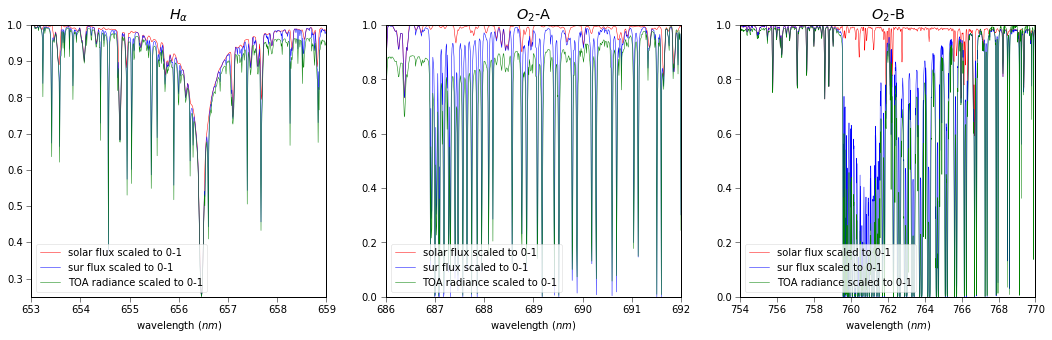

In [26]:
ret = np.genfromtxt('FLUORESCENCE.out')
wv, sur_flux,   _  = ret[::2].T
wv, solar_flux, uu = ret[1::2].T
Ha_mask   = (wv>=653) & (wv<=659)
O2_A_mask = (wv>=686) & (wv<=692)
O2_B_mask = (wv>=754) & (wv<=770)


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))

axs[0].plot(wv[Ha_mask],   solar_flux[Ha_mask]   / solar_flux[Ha_mask].max(),   '-', color='r', lw=0.5, label = 'solar flux scaled to 0-1')
axs[1].plot(wv[O2_A_mask], solar_flux[O2_A_mask] / solar_flux[O2_A_mask].max(), '-', color='r', lw=0.5, label = 'solar flux scaled to 0-1')
axs[2].plot(wv[O2_B_mask], solar_flux[O2_B_mask] / solar_flux[O2_B_mask].max(), '-', color='r', lw=0.5, label = 'solar flux scaled to 0-1')

axs[0].plot(wv[Ha_mask],   sur_flux[Ha_mask]   / sur_flux[Ha_mask].max(),   '-', color='b', lw=0.5, label = 'sur flux scaled to 0-1')
axs[1].plot(wv[O2_A_mask], sur_flux[O2_A_mask] / sur_flux[O2_A_mask].max(), '-', color='b', lw=0.5, label = 'sur flux scaled to 0-1')
axs[2].plot(wv[O2_B_mask], sur_flux[O2_B_mask] / sur_flux[O2_B_mask].max(), '-', color='b', lw=0.5, label = 'sur flux scaled to 0-1')


axs[0].plot(wv[Ha_mask],   uu[Ha_mask]   / uu[Ha_mask].max(),   '-', color='g', lw=0.5, label = 'TOA radiance scaled to 0-1')
axs[1].plot(wv[O2_A_mask], uu[O2_A_mask] / uu[O2_A_mask].max(), '-', color='g', lw=0.5, label = 'TOA radiance scaled to 0-1')
axs[2].plot(wv[O2_B_mask], uu[O2_B_mask] / uu[O2_B_mask].max(), '-', color='g', lw=0.5, label = 'TOA radiance scaled to 0-1')
axs[0].set_xlabel(r'wavelength ($nm$)')
axs[1].set_xlabel(r'wavelength ($nm$)')
axs[2].set_xlabel(r'wavelength ($nm$)')
#axs[0].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
#axs[1].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
#axs[2].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
axs[0].set_title(r'$H_{\alpha}$')
axs[1].set_title(r'$O_2$-A')
axs[2].set_title(r'$O_2$-B')
axs[0].legend(loc=3)
axs[1].legend(loc=3)
axs[2].legend(loc=3)


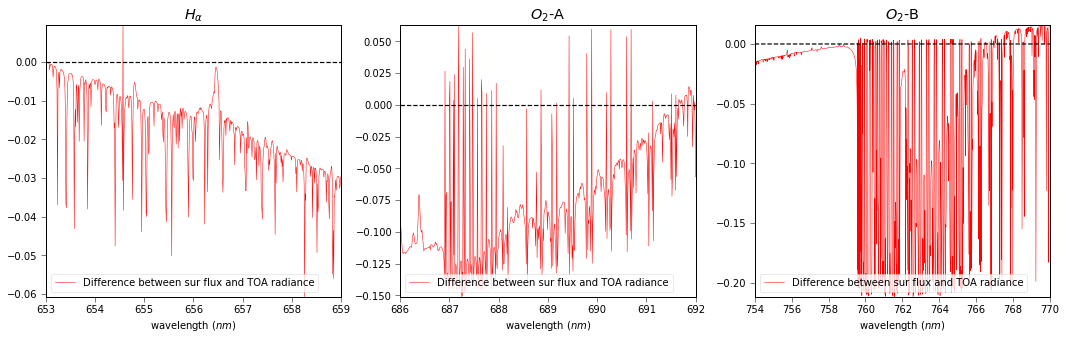

In [29]:
diff1 = uu[Ha_mask]   / uu[Ha_mask].max() -   sur_flux[Ha_mask] / sur_flux[Ha_mask].max()
diff2 = uu[O2_A_mask] / uu[O2_A_mask].max() - sur_flux[O2_A_mask] / sur_flux[O2_A_mask].max()
diff3 = uu[O2_B_mask] / uu[O2_B_mask].max() - sur_flux[O2_B_mask] / sur_flux[O2_B_mask].max()

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(18, 5))
axs[0].plot(wv[Ha_mask],   diff1, '-', color='r', lw=0.5, label = 'Difference between sur flux and TOA radiance')
axs[1].plot(wv[O2_A_mask], diff2, '-', color='r',   lw=0.5, label = 'Difference between sur flux and TOA radiance')
axs[2].plot(wv[O2_B_mask], diff3, '-', color='r',   lw=0.5, label = 'Difference between sur flux and TOA radiance')
axs[0].plot(wv[Ha_mask],   np.zeros_like(wv[Ha_mask]),   'k--')
axs[1].plot(wv[O2_A_mask], np.zeros_like(wv[O2_A_mask]), 'k--')
axs[2].plot(wv[O2_B_mask], np.zeros_like(wv[O2_B_mask]), 'k--')
axs[0].set_xlabel(r'wavelength ($nm$)')
axs[1].set_xlabel(r'wavelength ($nm$)')
axs[2].set_xlabel(r'wavelength ($nm$)')
#axs[0].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
#axs[1].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
#axs[2].set_ylabel(r'irradiance ($mW/m^2/nm/sr$)')
axs[0].set_title(r'$H_{\alpha}$')
axs[1].set_title(r'$O_2$-A')
axs[2].set_title(r'$O_2$-B')
axs[0].legend(loc=3)
axs[1].legend(loc=3)
axs[2].legend(loc=3)

From the scaled TOA and surface flux, we can see that those strong absorption rigion by hydrogen ($H$) (656.4 $nm$), $O_2$-B (687.0 $nm$) and $O_2$-A (760.4 $nm$) are filled in to have almost the same values as wavelength regions outside of them, which essentially coming from the fluorescence released by the vegetation.

From the above examples, I have shown the examples of using libRadtran to calculate very fine resolution atmospheric absorbtion lines in the analysis of fluorescence. It is very interesting to see the posibility of retrieving such tiny signal from space, e.g. [Global Solar-Induced Fluorescence](https://www.nasa.gov/jpl/oco2/pia18935) by NASA Orbiting Carbon Observatory-2 sensor.

Let's come back to atmospheric correction...

 

### Ways to calculate intrinsic path reflectance, spherical albedo and double transmittance

After checked some usages of libRadtran for atmospheric correction, I have seen there is a way of calculating those three atmospheric correction parameters differently from the way I have mentioned above:

1. Intrinsic path reflectance is calculated by setting the surface albedo to 0 then collect the refletance at TOA;
2. Upward transmittance is calculated by setting the solar zenith angle to be view zenith angle (reciprocity principle) and downward transmittance is calculated by using the original solar zenith angle;
3. The sphirical albedo is calculated by setting the surface albedo to be 1 ( this is problematic) by using the special module `disort_spherical_albedo`.

From here we start to use python directly call libRadtran and get the output without saving then into files:

In [17]:
import subprocess
from io import StringIO 
 
parameters = [ "sza", "vza", "raa", "aot", "wvc", "o3", 'ele']
 
def call_libradtran(inputs):
 
    process    = subprocess.Popen(                
                            "uvspec",                              
                            stdin=subprocess.PIPE,                 
                            stdout=subprocess.PIPE,                
                            stderr=subprocess.PIPE,                
                            shell=True)                                          
 
    ret, error = process.communicate(input=str.encode(inputs))
    ret, error = ret.decode(), error.decode()    
    ret        = np.genfromtxt(StringIO(ret))
    if len(error) > 0:
        raise OSError(error)
    else:
        return ret

def get_PathReflectance_SphericalAlbedo_TotalTransmittance(lib_path, tcwv, tco3, \
                                                           aot, sza, vza, raa, ele, verbose = False, sur = 0.1):
                        
    inp_temp = "data_files_path %s/ \
                \natmosphere_file US-standard\
                \nsource solar %s/solar_flux/kurudz_1.0nm.dat\
                \nmol_modify H2O %.6f MM\
                \nmol_modify O3 %.6f DU\
                \nmol_abs_param reptran coarse\
                \nrte_solver disort\
                \naerosol_default\
                \naerosol_species_file  continental_average\
                \naerosol_set_tau_at_wvl 550 %.6f\
                \nwavelength 340.00000000 2500.00000000\
                \nsza %.6f\
                \nphi0 0 # only raa maters raa = phi-phi0 (vaa - saa)\
                \numu %.6f\
                \nphi %.6f\
                \nalbedo %.6f\
                \naltitude %.3f\
                \noutput_quantity transmittance\
                \nzout %s\
                \noutput_user lambda %s\
                \nquiet"
    sur1, sur2   = 0.15, 0.5
    # this might be problematic due to the lose of radiation loss of black surface
    path_ref_inp = inp_temp % (lib_path, lib_path, tcwv, tco3, aot, sza, np.cos(np.deg2rad(vza)), raa, 0.0,  ele, 'toa', 'uu') 
    t1_inp       = inp_temp % (lib_path, lib_path, tcwv, tco3, aot, vza, np.cos(np.deg2rad(vza)), raa, 0.0,  ele, 'sur', 'eglo')
    t2_inp       = inp_temp % (lib_path, lib_path, tcwv, tco3, aot, sza, np.cos(np.deg2rad(vza)), raa, 0.0,  ele, 'sur', 'eglo')
    sph_alb_inp1 = inp_temp % (lib_path, lib_path, tcwv, tco3, aot, sza, np.cos(np.deg2rad(vza)), raa, sur1, ele, 'sur', 'eglo')
    sph_alb_inp2 = inp_temp % (lib_path, lib_path, tcwv, tco3, aot, sza, np.cos(np.deg2rad(vza)), raa, sur2, ele, 'sur', 'eglo')
    toa_inp      = inp_temp % (lib_path, lib_path, tcwv, tco3, aot, sza, np.cos(np.deg2rad(vza)), raa, sur,  ele, 'toa', 'uu')
    if verbose:
        print(path_ref_inp) 
        print(t1_inp)       
        print(t2_inp)       
        print(sph_alb_inp)       
    # the atmosphere path transmittance 
    wv, path_ref = call_libradtran(path_ref_inp).T
    path_ref     = path_ref * np.pi / np.cos(np.deg2rad(sza))
 
    # spherical albedo
    # run with roh 1 = 0.15 
    wv, s1   = call_libradtran(sph_alb_inp1).T
    # run with roh 2 = 0.50
    wv, s2   = call_libradtran(sph_alb_inp2).T
    sph_alb  = (s2 - s1) / (sur2 * s2 -  sur1 * s1)
 
    # double transmittance                                         
    # the downward transmittance
    wv, t1 = call_libradtran(t1_inp).T 
    # the upward transmittance
    wv, t2 = call_libradtran(t2_inp).T 
    t1     = t1 / np.cos(np.deg2rad(sza))
    t2     = t2 / np.cos(np.deg2rad(vza))
    tt     = t1 * t2
 
    # the true TOA
    wv,  toa   = call_libradtran(toa_inp).T
    toa        = toa * np.pi / np.cos(np.deg2rad(sza)) 
      
    return wv / 1000., path_ref, tt, sph_alb, toa

In [21]:
lib_path = 'libRadtran-2.0.2/data'
sixs_path = '6SV2.1/sixsV2.1'          
atmo_window_wv1 = np.array([0.350, 0.400, 0.412, 0.443, 0.470, 0.488, 0.515, 0.550, 0.590, 0.633, 0.670, 0.694, 0.760, 0.860, 1.240, 1.536, 1.650, 1.950, 2.250, 3.750])
atmo_window_wv2 = np.array([0.350, 0.400, 0.412, 0.443, 0.470, 0.488, 0.525, 0.550, 0.610, 0.640, 0.670, 0.750, 0.870, 1.035, 1.240, 1.536, 1.650, 2.10, 2.250, 3.750])
aot, tcwv, tco3, ele = 0.5, 30, 300, 0.1
sza, vza, raa        = 10, 10, 50
wv, path_ref, tt, sph_alb, toa = get_PathReflectance_SphericalAlbedo_TotalTransmittance(\
                                            lib_path, tcwv, tco3, aot, sza, vza, raa, ele, verbose = False)

/home/ucfafyi/.conda/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in true_divide
